# SETUP

## INSTALLS

In [4]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [1]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install pypots

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 33.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 39.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.3 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-_s2c3rxj
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-_s2c3rxj
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit bd8759a416a0c0d6d56d5b53d4ec21927290a4d2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=12

In [2]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 37.7 MB/s eta 0:00:00


In [3]:
!pip install pytorch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 16.9 MB/s eta 0:00:00


In [5]:
!mkdir -p datasets/knmi_station_data
!cp -r /content/drive/MyDrive/MAGISTERKA/datasets/knmi_station_data ./datasets/

## Imports

In [27]:
from collections import Counter
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from pypots.utils.random import set_random_seed
from pypots.optim import Adam
from pypots.classification import Raindrop, BRITS, GRUD
from pypots.nn.functional import calc_binary_classification_metrics, calc_mse, calc_rmse, calc_mae
from pypots.nn.modules.loss import Criterion, MSE, MAE
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_forecasting.data.timeseries import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.models import Baseline, TemporalFusionTransformer, LSTM, GRU, NHiTS, RecurrentNetwork
from pytorch_forecasting.metrics import MAE, RMSE, MASE

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner
from torchmetrics import Metric

In [7]:
BASE_PATH = Path("/content")
DRIVE_PATH = Path("/content/drive/MyDrive/MAGISTERKA")
SAVE_DIR = DRIVE_PATH / "lightning_logs/runs/forecast"

# Prepare df

In [8]:
stations = '249','323', '377'
# stations = '323',
test_station = '215'

In [9]:
def _convert_vv_to_meters(vv_code):
    if pd.isna(vv_code):
        return np.nan

    vv_code = int(vv_code)

    if 0 <= vv_code <= 49:
        return vv_code * 100 + 50
    elif vv_code == 50:
        return 5500
    elif 51 <= vv_code <= 55:
        return np.nan
    elif 56 <= vv_code <= 79:
        return int((vv_code - 56 + 6.5) * 1000)
    elif vv_code == 80:
        return 32500
    elif 81 <= vv_code <= 88:
        return int(32500 + (vv_code - 81) * 5000)
    elif vv_code == 89:
        return 70000
    else:
        return np.nan

def _get_valid_vv_codes() -> list[int]:
    valid_codes = list(range(0, 51))
    valid_codes += list(range(56, 90))
    return valid_codes

def get_vv_one_hot_encoder() -> OneHotEncoder:
    valid_codes = _get_valid_vv_codes()
    categories = [np.array(valid_codes, dtype=np.int32)]
    encoder = OneHotEncoder(categories=categories, handle_unknown='ignore', dtype=np.float32, sparse_output=False)
    encoder.fit(categories[0].reshape(-1, 1))
    return encoder

def prepare_df(path: str) -> pd.DataFrame:
    try:
        header_line_index = -1
        column_names = []
        data_lines_start_index = -1

        # Find the header and its index more efficiently
        with open(path, 'r') as f:
            for i, line in enumerate(f):
                if line.strip().startswith('# STN,YYYYMMDD,'):
                    header_line_index = i
                    column_names = [col.strip() for col in line.strip().lstrip('#').split(',')]
                    data_lines_start_index = header_line_index + 1
                    break

        if header_line_index == -1:
            raise ValueError("Header line not found.")

        # Use pandas.read_csv directly with skiprows and comment character
        # This avoids reading the whole file into a list first for data lines
        # and then joining them back.
        df = pd.read_csv(
            path,
            names=column_names,
            skiprows=data_lines_start_index,
            comment='#',  # Lines starting with '#' will be ignored as comments
            skipinitialspace=True,
            na_values=['       ', '     '] # Add other common missing value representations if needed
        )

        if df.empty:
            raise ValueError("No data found after the header or all data was commented out.")

        # Convert 'HH' to string and zfill, then create 'Timestamp'
        # It's crucial to handle potential NaN values in 'YYYYMMDD' or 'HH'
        # if they are not guaranteed to be present or valid in all rows.
        df['HH'] = df['HH'].astype(int) - 1
        df['HH'] = df['HH'].astype(str).str.zfill(2)
        df['Timestamp'] = pd.to_datetime(df['YYYYMMDD'].astype(str) + df['HH'].astype(str), format="%Y%m%d%H", errors='coerce')

        df.set_index('Timestamp', inplace=True)

        # Columns to drop
        cols_to_drop = ['YYYYMMDD', 'HH']
        df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

        # Convert remaining columns to numeric, efficiently
        # Identify numeric columns once and convert
        # Exclude already processed or known non-numeric columns if necessary
        for col in df.columns:
            # This check is slightly redundant if YYYYMMDD and HH are already dropped,
            # but good for safety if they weren't or if other non-numeric columns exist.
            if df[col].dtype == 'object': # Only attempt conversion if the column is of object type
                try:
                    df[col] = pd.to_numeric(df[col], downcast='signed')
                except ValueError:
                    # Handle or log cases where a column expected to be numeric isn't
                    # For now, we'll coerce, which turns unparseable into NaT/NaN
                    df[col] = pd.to_numeric(df[col], errors='coerce', downcast='signed')
        df['VV_m'] = df['VV'].apply(_convert_vv_to_meters)
        return df

    except FileNotFoundError:
        print(f"Error: The file '{path}' was not found.")
        raise
    except ValueError as ve:
        print(f"ValueError: {ve}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

In [10]:
dfs = []
for station in stations:
    df = prepare_df(f"./datasets/knmi_station_data/{station}.txt")
    df = df.set_index('STN', append=True)
    # Check whether VV column has any noy nulls
    nulls = df['VV'].isna().sum()
    dfs.append(df)

train_df = pd.concat(dfs)
train_df = df.reset_index()
train_df.head()

,Timestamp,STN,DD,FH,FF,FX,T,T10N,TD,SQ,...,N,U,WW,IX,M,R,S,O,Y,VV_m
0,2000-01-01 00:00:00,377,220,30,30,50,46,NaN,39,0,...,NaN,95,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-01 01:00:00,377,210,30,30,50,47,NaN,41,0,...,NaN,96,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-01 02:00:00,377,210,30,30,50,48,NaN,44,0,...,NaN,97,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-01 03:00:00,377,200,30,30,50,49,NaN,45,0,...,NaN,97,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-01 04:00:00,377,200,30,30,50,50,NaN,46,0,...,NaN,97,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88104 entries, 0 to 88103
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  88104 non-null  datetime64[ns]
 1   STN        88104 non-null  int64         
 2   DD         88104 non-null  int64         
 3   FH         88104 non-null  int64         
 4   FF         88104 non-null  int64         
 5   FX         88104 non-null  int64         
 6   T          88104 non-null  int64         
 7   T10N       14682 non-null  float64       
 8   TD         88104 non-null  int64         
 9   SQ         88104 non-null  int64         
 10  Q          88104 non-null  int64         
 11  DR         88104 non-null  int64         
 12  RH         88104 non-null  int64         
 13  P          0 non-null      float64       
 14  VV         77850 non-null  float64       
 15  N          77775 non-null  float64       
 16  U          88104 non-null  int64        

In [12]:
dfs = []
for station in [test_station]:
    df = prepare_df(f"./datasets/knmi_station_data/{station}.txt")
    df = df.set_index('STN', append=True)
    # Check whether VV column has any noy nulls
    nulls = df['VV'].isna().sum()
    dfs.append(df)

test_df = pd.concat(dfs)
test_df = df.reset_index()
test_df.head()

,Timestamp,STN,DD,FH,FF,FX,T,T10N,TD,SQ,...,N,U,WW,IX,M,R,S,O,Y,VV_m
0,2015-01-01 00:00:00,215,210.0,50.0,50.0,70.0,27,NaN,8,0,...,0.0,87,10.0,7,0.0,0.0,0.0,0.0,0.0,4250.0
1,2015-01-01 01:00:00,215,220.0,50.0,50.0,70.0,26,NaN,4,0,...,0.0,85,10.0,7,0.0,0.0,0.0,0.0,0.0,7500.0
2,2015-01-01 02:00:00,215,200.0,50.0,40.0,80.0,23,NaN,2,0,...,0.0,86,NaN,5,0.0,0.0,0.0,0.0,0.0,10500.0
3,2015-01-01 03:00:00,215,210.0,40.0,40.0,70.0,21,NaN,1,0,...,0.0,87,NaN,5,0.0,0.0,0.0,0.0,0.0,10500.0
4,2015-01-01 04:00:00,215,190.0,50.0,50.0,80.0,19,NaN,2,0,...,1.0,88,NaN,5,0.0,0.0,0.0,0.0,0.0,10500.0


In [13]:
SEQUENCE_LENGTH = 12
STEP_SIZE = 1
TARGET_COLUMN = 'VV_m'
NUMERICAL_COLS = [
    "FH", "FF", "FX", "T", "T10N", "TD", "SQ", "Q", "DR", "RH", "P", "U",
    # "DD"
]
CATEGORICAL_COLS = {
    # "WW", "IX", "VV"
}

vv_encoder = get_vv_one_hot_encoder()


# Pytorch forecasting dataset

In [42]:
def prepare_forecasting_df(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()
  df = df[df['VV_m'].notna()]

  prepared_dfs = []
  for station in df['STN'].unique():
    station_df = df[df['STN'] == station]
    station_df = station_df.sort_values('Timestamp').reset_index(drop=True)
    valid_times = station_df['Timestamp'].sort_values().reset_index(drop=True)
    time_diffs = valid_times.diff().fillna(pd.Timedelta(seconds=0))
    group = (time_diffs > pd.Timedelta(hours=1)).cumsum()
    station_df['TimeGroup'] = group
    station_df['TimeIdx'] = station_df.groupby('TimeGroup').cumcount()
    prepared_dfs.append(station_df)
  return pd.concat(prepared_dfs, axis=0).fillna(-1)

In [43]:
train_df_v2 = prepare_forecasting_df(train_df)
test_df_v2 = prepare_forecasting_df(test_df)

In [44]:
TRAIN_CUTOFF = pd.to_datetime('2021-01-01')
train_dataset = TimeSeriesDataSet(
    data=train_df_v2[train_df_v2['Timestamp'] < TRAIN_CUTOFF],
    time_idx='TimeIdx',
    target='VV_m',
    group_ids=['STN', 'TimeGroup'],
    min_encoder_length=8,
    max_encoder_length=8,
    min_prediction_length=1,
    max_prediction_length=1,
    time_varying_known_reals=NUMERICAL_COLS,
    time_varying_unknown_reals=[TARGET_COLUMN],
    add_relative_time_idx=False,
    categorical_encoders={
        'TimeGroup': NaNLabelEncoder(add_nan=True, warn=False),
        'STN': NaNLabelEncoder(add_nan=True, warn=False),
    }
)
validation_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    train_df_v2[train_df_v2['Timestamp'] >= TRAIN_CUTOFF],
    stop_randomization=True,
)
train_dataset

TimeSeriesDataSet[length=60786](
	time_idx='TimeIdx',
	target='VV_m',
	group_ids=['STN', 'TimeGroup'],
	weight=None,
	max_encoder_length=8,
	min_encoder_length=8,
	min_prediction_idx=0,
	min_prediction_length=1,
	max_prediction_length=1,
	static_categoricals=None,
	static_reals=None,
	time_varying_known_categoricals=None,
	time_varying_known_reals=['FH', 'FF', 'FX', 'T', 'T10N', 'TD', 'SQ', 'Q', 'DR', 'RH', 'P', 'U'],
	time_varying_unknown_categoricals=None,
	time_varying_unknown_reals=['VV_m'],
	variable_groups=None,
	constant_fill_strategy=None,
	allow_missing_timesteps=False,
	lags=None,
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=None,
	center=True,
	scale_by_group=False,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'TimeGroup': NaNLabelEncoder(add_nan=True, warn=False), 'STN': NaNLabelEncoder(add_nan=True, warn=False), '__group_id__STN': NaNLabelEncoder(add

In [45]:
target = train_df_v2.loc[train_dataset.index.index, "VV_m"].to_numpy()
probabilities = np.ones_like(target)
probabilities[target < 5000] = 3
probabilities[target < 3000] = 5
probabilities[target < 1000] = 10

train_dl = train_dataset.to_dataloader(
  batch_size=64,
  sampler=WeightedRandomSampler(weights=probabilities, num_samples=len(probabilities), replacement=True),
  shuffle=False,
  num_workers=0
)

In [46]:
# target = train_df_v2.loc[validation_dataset.index.index, "VV_m"].to_numpy()
# probabilities = np.ones_like(target)
# probabilities[target < 5000] = 3
# probabilities[target < 3000] = 5
# probabilities[target < 1000] = 10

validation_dl = validation_dataset.to_dataloader(
  batch_size=64 * 10,
  # sampler=WeightedRandomSampler(weights=probabilities, num_samples=len(probabilities), replacement=True),
  shuffle=False,
  num_workers=0,
  drop_last=True
)

# Metrics

In [19]:
def prepare_predictions(model, dataloader):
  ys_pred = []
  ys_true = []
  for x, y in iter(dataloader):
    y_pred = model.forward(x)
    ys_pred.append(torch.squeeze(y_pred.prediction.detach()))
    ys_true.append(torch.squeeze(y[0]))

  ys_pred = torch.cat(ys_pred)
  ys_true = torch.cat(ys_true)

  # For each unique value in ys_true calculate mean prediction and std of prediction
  ys_true_unique = ys_true.unique()
  ys_pred_mean = []
  ys_pred_std = []
  ys_pred_all = []

  for unique_value in ys_true_unique:
    mask = ys_true == unique_value
    ys_pred_mean.append(ys_pred[mask].mean())
    ys_pred_std.append(ys_pred[mask].std())
    ys_pred_all.append(ys_pred[mask])

  ys_pred_mean = torch.tensor(ys_pred_mean)
  ys_pred_std = torch.tensor(ys_pred_std)

  return ys_pred_all, ys_true_unique, ys_pred_mean, ys_pred_std

In [20]:
def boxplot_predictions(ys_pred_all, ys_true_unique):
  # On X ys_true, sorted from smallest to biggest
  # On Y boxplot of preds for this next x's
  max_pred = ys_pred_all[0].max()
  for i in range(1, len(ys_pred_all)):
    max_pred = max(max_pred, ys_pred_all[i].max())
  fig, ax = plt.subplots(figsize=(16, 10))

  data = []
  for preds, true in zip(ys_pred_all, ys_true_unique):
    for pred in preds:
      data.append((true.item(), pred.item()))
  df = pd.DataFrame(data, columns=['true', 'pred'])
  sns.boxplot(x='true', y='pred', data=df, ax=ax)
  # Rotate xticks
  plt.xticks(rotation=90)

In [21]:
def boxplot_predictions_zoomed(ys_pred_all, ys_true_unique, max_y=5000):
  ys_pred_all_ = []
  ys_preds_unique_ = []
  for preds, true in zip(ys_pred_all, ys_true_unique):
    if true <= max_y:
      ys_pred_all_.append(preds)
      ys_preds_unique_.append(true)
  ys_preds_unique_ = torch.tensor(ys_preds_unique_)
  max_pred = ys_pred_all_[0].max()
  for i in range(1, len(ys_pred_all_)):
    max_pred = max(max_pred, ys_pred_all_[i].max())

  data = []
  for preds, true in zip(ys_pred_all_, ys_preds_unique_):
    for pred in preds:
      data.append((true.item(), pred.item()))
  df = pd.DataFrame(data, columns=['true', 'pred'])
  fig, ax = plt.subplots(figsize=(16, 10))
  sns.boxplot(x='true', y='pred', data=df, ax=ax)
  # Rotate xticks
  plt.xticks(rotation=90)


In [51]:
def calculate_metrics(ys_pred_all, ys_true_unique, splits: list[int] = [500, 1000, 2000, 5000, 10000]):
  # splits is <min, max> so for this array it will be for 0-500, 500-1000, 1000-2000, 2000-5000, 5000-10000, 10000-MAX
  results = {}
  min_value = ys_true_unique.min().item()
  max_value = ys_true_unique.max().item()
  for min_y, max_y in zip([min_value] + splits, splits + [max_value]):
    mask = (ys_true_unique >= min_y) & (ys_true_unique < max_y)
    ys_true_filtered = ys_true_unique[mask]
    ys_pred_filtered = []
    for i, v in enumerate(mask):
      if v:
        ys_pred_filtered.append(ys_pred_all[i])
    ys_pred = []
    ys_true = []
    for preds, true in zip(ys_pred_filtered, ys_true_filtered):
      for pred in preds:
        ys_pred.append(pred.item())
        ys_true.append(true.item())
    ys_pred = torch.tensor(ys_pred).unsqueeze(-1)
    ys_true = torch.tensor(ys_true).unsqueeze(-1)
    mae = MAE()(ys_pred, ys_true)
    rmse = RMSE()(ys_pred, ys_true)
    results[f"{int(min_y)}-{int(max_y)}"] = {
        "mae": mae.item(),
        "rmse": rmse.item(),
    }
  return results

def average_metrics(metrics: list[dict[dict[str, float]]]):
  results = {}
  # metrics is list of:
  # {'50-500': {'mae': 752.0321044921875, 'rmse': 934.5390014648438},
  #  '500-1000': {'mae': 723.1170043945312, 'rmse': 1165.4361572265625},
  #  '1000-2000': {'mae': 1082.502197265625, 'rmse': 1697.314453125},
  #  '2000-5000': {'mae': 1743.2655029296875, 'rmse': 2340.599609375},
  #  '5000-10000': {'mae': 3225.502685546875, 'rmse': 3892.3681640625},
  #  '10000-47500': {'mae': 9657.6806640625, 'rmse': 10859.7509765625}}
  for metrics_dict in metrics:
    for split, metrics in metrics_dict.items():
      if split not in results:
        results[split] = {}
      for metric, value in metrics.items():
        if metric not in results[split]:
          results[split][metric] = []
        results[split][metric].append(value)

  for split, metrics_dict in results.items():
    for metric, values in metrics_dict.items():
      mean = np.mean(values)
      std = np.std(values)
      results[split][metric] = {
          "mean": float(mean),
          "std": float(std),
      }
  return results

average_metrics([
      {'50-500': {'mae': 752.0321044921875, 'rmse': 934.5390014648438},
   '500-1000': {'mae': 723.1170043945312, 'rmse': 1165.4361572265625},
   '1000-2000': {'mae': 1082.502197265625, 'rmse': 1697.314453125},
   '2000-5000': {'mae': 1743.2655029296875, 'rmse': 2340.599609375},
   '5000-10000': {'mae': 3225.502685546875, 'rmse': 3892.3681640625},
   '10000-47500': {'mae': 9657.6806640625, 'rmse': 10859.7509765625}}
])

{'50-500': {'mae': {'mean': 752.0321044921875, 'std': 0.0},
  'rmse': {'mean': 934.5390014648438, 'std': 0.0}},
 '500-1000': {'mae': {'mean': 723.1170043945312, 'std': 0.0},
  'rmse': {'mean': 1165.4361572265625, 'std': 0.0}},
 '1000-2000': {'mae': {'mean': 1082.502197265625, 'std': 0.0},
  'rmse': {'mean': 1697.314453125, 'std': 0.0}},
 '2000-5000': {'mae': {'mean': 1743.2655029296875, 'std': 0.0},
  'rmse': {'mean': 2340.599609375, 'std': 0.0}},
 '5000-10000': {'mae': {'mean': 3225.502685546875, 'std': 0.0},
  'rmse': {'mean': 3892.3681640625, 'std': 0.0}},
 '10000-47500': {'mae': {'mean': 9657.6806640625, 'std': 0.0},
  'rmse': {'mean': 10859.7509765625, 'std': 0.0}}}

# Baseline

In [ ]:
baseline_predictions = Baseline().predict(validation_dl, return_y=False)
# MAE(baseline_predictions.output, baseline_predictions.y), RMSE(baseline_predictions.output, baseline_predictions.y)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU availabl

In [ ]:
baseline_predictions.shape

torch.Size([16856, 1])

In [ ]:
y_true = []
for batch in validation_dl:
  y_true.append(batch[0]['decoder_target'].squeeze())
y_true = torch.cat(y_true).unsqueeze(-1)
y_true.shape

torch.Size([16832, 1])

In [ ]:
MAE()(baseline_predictions[:(len(y_true))], y_true)

tensor(3232.5925)

# Custom loss

In [52]:
class VisibilityLoss(Metric):
    def __init__(self, alpha=3.0, beta=1.5, gamma=1.0, dist_sync_on_step=False):
        """
        alpha: weight for visibility < 1000m
        beta: weight for visibility between 1000–5000m
        gamma: weight for visibility > 5000m
        """
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        self.add_state("squared_errors_sum", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("weights_sum", default=torch.tensor(0.0), dist_reduce_fx="sum")


    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        # Ensure tensors are on the same device if necessary
        y_pred = y_pred.to(self.squared_errors_sum.device)
        y_true = y_true.to(self.squared_errors_sum.device)

        log_pred = torch.log1p(y_pred)
        log_true = torch.log1p(y_true)
        error = (log_pred - log_true) ** 2

        weights = torch.where(
            y_true < 1000, self.alpha,
            torch.where(y_true < 5000, self.beta, self.gamma)
        )

        self.squared_errors_sum += (weights * error).sum()
        self.weights_sum += weights.sum()

    def compute(self):
        # Calculate the weighted mean squared error
        return self.squared_errors_sum / self.weights_sum if self.weights_sum > 0 else torch.tensor(0.0)


class Log1PMSE(Metric):
    def __init__(self, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)

        # Define state variables for accumulating results
        self.add_state("sum_sq_err", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        # Ensure tensors are on the same device if necessary
        y_pred = y_pred.to(self.sum_sq_err.device)
        y_true = y_true.to(self.sum_sq_err.device)

        log_pred = torch.log1p(y_pred)
        log_true = torch.log1p(y_true)

        self.sum_sq_err += F.mse_loss(log_pred, log_true, reduction='sum')
        self.total += y_true.numel()

    def compute(self):
        return self.sum_sq_err / self.total if self.total > 0 else torch.tensor(0.0)

# Model training

In [ ]:
trainer = L.Trainer(
    accelerator="cpu",
    gradient_clip_val=0.1
)

tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=0.03,
    hidden_size=8,
    # Up to 4 recommended
    attention_head_size=1,
    # Recommended 0.1-0.3
    dropout=0.1,
    # Should be <= than hidden_size
    hidden_continuous_size=8,
    loss=RMSE(),
    # optimizer="ranger"
)

print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 13.7k


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
trainer.validate(tft, validation_dl)

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │      10982.009765625      │
│         val_MAPE          │    2.2857372760772705     │
│         val_RMSE          │     13101.9130859375      │
│         val_SMAPE         │    0.5532400608062744     │
│         val_loss          │     13101.9130859375      │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 13101.9130859375,
  'val_SMAPE': 0.5532400608062744,
  'val_MAE': 10982.009765625,
  'val_RMSE': 13101.9130859375,
  'val_MAPE': 2.2857372760772705}]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.011481536214968821
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.011481536214968821
INFO: Restoring states from the checkpoint path at /content/.lr_find_5505ec5e-6085-4e57-aea6-670a2a4160b5.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_5505ec5e-6085-4e57-aea6-670a2a4160b5.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_5505ec5e-6085-4e57-aea6-670a2a4160b5.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_5505ec5e-6085-4e57-aea6-670a2a4160b5.ckpt


suggested learning rate: 0.011481536214968821


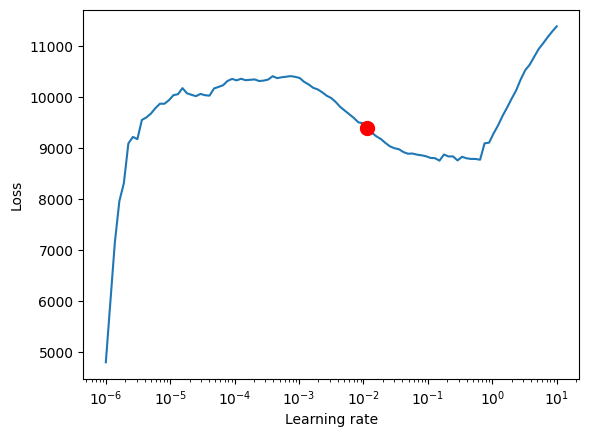

In [ ]:
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dl,
    val_dataloaders=validation_dl,
    max_lr=10,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# RUNS

In [53]:
MODEL = 'NHiTS'
metrics = []
for i in range(5):
  trainer = L.Trainer(
    max_epochs=100,
    logger=L.pytorch.loggers.TensorBoardLogger(
        save_dir=SAVE_DIR / MODEL,
        name=MODEL,
        version=f"1000{i:02}",
    ),
    callbacks=[
        L.pytorch.callbacks.early_stopping.EarlyStopping(
            monitor="val_loss", mode="min", patience=5, verbose=False
        ),
        L.pytorch.callbacks.ModelCheckpoint(
            monitor="val_loss",
            mode="max",
            dirpath=SAVE_DIR / MODEL,
            filename=MODEL,
        ),
    ],
    log_every_n_steps=1,
    gradient_clip_val=0.1,
    # fast_dev_run=True
  )

  tft = NHiTS.from_dataset(
      train_dataset,
      learning_rate=0.03,
      # size of hidden layers and can range from 8 to 1024 - use 32-128 if no covariates are employed. Defaults to 512.
      hidden_size=32,
      # Recommended 0.1-0.3
      dropout=0.1,
      # Should be <= than hidden_size
      loss=MASE(),
      # loss=Log1PMSE(),
      # learning_rate=0.01,
      # optimizer="ranger"
  )

  trainer.fit(tft, train_dataloaders=train_dl, val_dataloaders=validation_dl)

  ys_pred_all, ys_true_unique, ys_pred_mean, ys_pred_std = prepare_predictions(tft, validation_dl)
  metrics.append(calculate_metrics(ys_pred_all, ys_true_unique))

average_metrics(metrics)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | MASE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 15.3 K | train
-----------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_su

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | MASE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 15.3 K | train
-----------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_su

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | MASE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 15.3 K | train
-----------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_su

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | MASE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 15.3 K | train
-----------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_su

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

{'50-500': {'mae': {'mean': 1193.2462036132813, 'std': 203.44786150876553},
  'rmse': {'mean': 2860.0462890625, 'std': 151.71159023929275}},
 '500-1000': {'mae': {'mean': 1625.4093505859375, 'std': 136.2801369635947},
  'rmse': {'mean': 3460.13134765625, 'std': 185.42086079989454}},
 '1000-2000': {'mae': {'mean': 2359.419384765625, 'std': 141.47969493844673},
  'rmse': {'mean': 5204.759375, 'std': 458.1028290135379}},
 '2000-5000': {'mae': {'mean': 2282.4896484375, 'std': 70.12785421359722},
  'rmse': {'mean': 4509.25556640625, 'std': 170.54178222282638}},
 '5000-10000': {'mae': {'mean': 3378.066162109375, 'std': 103.26926903548349},
  'rmse': {'mean': 5760.91220703125, 'std': 250.21741318918373}},
 '10000-47500': {'mae': {'mean': 3854.112255859375, 'std': 230.96780265101822},
  'rmse': {'mean': 6000.94248046875, 'std': 118.01461793881734}}}

In [54]:
MODEL = 'NHiTS'
metrics = []
for i in range(5):
  trainer = L.Trainer(
    max_epochs=100,
    logger=L.pytorch.loggers.TensorBoardLogger(
        save_dir=SAVE_DIR / MODEL,
        name=MODEL,
        version=f"1000{i:02}",
    ),
    callbacks=[
        L.pytorch.callbacks.early_stopping.EarlyStopping(
            monitor="val_loss", mode="min", patience=5, verbose=False
        ),
        L.pytorch.callbacks.ModelCheckpoint(
            monitor="val_loss",
            mode="max",
            dirpath=SAVE_DIR / MODEL,
            filename=MODEL,
        ),
    ],
    log_every_n_steps=1,
    gradient_clip_val=0.1,
    # fast_dev_run=True
  )

  tft = NHiTS.from_dataset(
      train_dataset,
      learning_rate=0.03,
      # size of hidden layers and can range from 8 to 1024 - use 32-128 if no covariates are employed. Defaults to 512.
      hidden_size=32,
      # Recommended 0.1-0.3
      dropout=0.1,
      # Should be <= than hidden_size
      # loss=MASE(),
      loss=Log1PMSE(),
      # learning_rate=0.01,
      # optimizer="ranger"
  )

  trainer.fit(tft, train_dataloaders=train_dl, val_dataloaders=validation_dl)

  ys_pred_all, ys_true_unique, ys_pred_mean, ys_pred_std = prepare_predictions(tft, validation_dl)
  metrics.append(calculate_metrics(ys_pred_all, ys_true_unique))

average_metrics(metrics)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | NHiTS              | 15.3 K | train
---------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
INFO:lightnin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | NHiTS              | 15.3 K | train
---------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
INFO:lightnin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | NHiTS              | 15.3 K | train
---------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
INFO:lightnin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | NHiTS              | 15.3 K | train
---------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
INFO:lightnin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | NHiTS              | 15.3 K | train
---------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
INFO:lightnin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

{'50-500': {'mae': {'mean': 1660.6127807617188, 'std': 777.7438785769875},
  'rmse': {'mean': 3202.750146484375, 'std': 472.63894995652896}},
 '500-1000': {'mae': {'mean': 2029.568701171875, 'std': 595.9111655658818},
  'rmse': {'mean': 3725.4953125, 'std': 365.55620453682013}},
 '1000-2000': {'mae': {'mean': 2671.515576171875, 'std': 425.54176046191077},
  'rmse': {'mean': 5561.14765625, 'std': 342.5957182000629}},
 '2000-5000': {'mae': {'mean': 2530.6171875, 'std': 302.5485429198599},
  'rmse': {'mean': 4695.5541015625, 'std': 188.6061647202535}},
 '5000-10000': {'mae': {'mean': 3576.9853515625, 'std': 202.27458013072064},
  'rmse': {'mean': 5959.562109375, 'std': 261.71775477076545}},
 '10000-47500': {'mae': {'mean': 4046.631640625, 'std': 162.63503668850797},
  'rmse': {'mean': 6182.255078125, 'std': 179.89618025605532}}}

In [55]:
MODEL = 'NHiTS'
metrics = []
for i in range(5):
  trainer = L.Trainer(
    max_epochs=100,
    logger=L.pytorch.loggers.TensorBoardLogger(
        save_dir=SAVE_DIR / MODEL,
        name=MODEL,
        version=f"1000{i:02}",
    ),
    callbacks=[
        L.pytorch.callbacks.early_stopping.EarlyStopping(
            monitor="val_loss", mode="min", patience=5, verbose=False
        ),
        L.pytorch.callbacks.ModelCheckpoint(
            monitor="val_loss",
            mode="max",
            dirpath=SAVE_DIR / MODEL,
            filename=MODEL,
        ),
    ],
    log_every_n_steps=1,
    gradient_clip_val=0.1,
    # fast_dev_run=True
  )

  tft = NHiTS.from_dataset(
      train_dataset,
      learning_rate=0.03,
      # size of hidden layers and can range from 8 to 1024 - use 32-128 if no covariates are employed. Defaults to 512.
      hidden_size=32,
      # Recommended 0.1-0.3
      dropout=0.1,
      # Should be <= than hidden_size
      loss=VisibilityLoss(),
      # loss=Log1PMSE(),
      # learning_rate=0.01,
      # optimizer="ranger"
  )

  trainer.fit(tft, train_dataloaders=train_dl, val_dataloaders=validation_dl)

  ys_pred_all, ys_true_unique, ys_pred_mean, ys_pred_std = prepare_predictions(tft, validation_dl)
  metrics.append(calculate_metrics(ys_pred_all, ys_true_unique))

average_metrics(metrics)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | NHiTS              | 15.3 K | train
---------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
INFO:lightnin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | NHiTS              | 15.3 K | train
---------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
INFO:lightnin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | NHiTS              | 15.3 K | train
---------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
INFO:lightnin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | NHiTS              | 15.3 K | train
---------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
INFO:lightnin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | NHiTS              | 15.3 K | train
---------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
INFO:lightnin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

{'50-500': {'mae': {'mean': 987.4295166015625, 'std': 141.8720127402885},
  'rmse': {'mean': 2790.6416015625, 'std': 215.28955514658153}},
 '500-1000': {'mae': {'mean': 1524.107470703125, 'std': 118.54693168493475},
  'rmse': {'mean': 3448.7146484375, 'std': 134.16241174071394}},
 '1000-2000': {'mae': {'mean': 2351.95830078125, 'std': 67.81870303782962},
  'rmse': {'mean': 5314.15302734375, 'std': 133.63463488515322}},
 '2000-5000': {'mae': {'mean': 2390.488818359375, 'std': 226.33486620493022},
  'rmse': {'mean': 4619.15849609375, 'std': 178.88782199742408}},
 '5000-10000': {'mae': {'mean': 3508.61630859375, 'std': 195.29951668960052},
  'rmse': {'mean': 5925.0068359375, 'std': 182.28440496865582}},
 '10000-47500': {'mae': {'mean': 4000.71083984375, 'std': 424.37687147204264},
  'rmse': {'mean': 6378.610546875, 'std': 606.9749416046793}}}

# Not deep models

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.base import ClassifierMixin
from typing import Any, TypeVar
from collections import namedtuple
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
_T = TypeVar('_T', bound=ClassifierMixin)

def evaluate_model(model: ClassifierMixin, X: Any, y: Any):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='macro')
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    confusion = confusion_matrix(y, y_pred)
    return namedtuple('Evaluation', ['accuracy', 'f1', 'precision', 'recall', 'confusion'])(accuracy, f1, precision, recall, confusion)

def train_model(
        model_cls: _T,
        model_kwargs: dict[str, Any],
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray
    ) -> _T:
    model = model_cls(**model_kwargs)
    if X_train.ndim == 3:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
    if X_test.ndim == 3:
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

    X_train = np.nan_to_num(X_train, nan=-1.0)
    X_test = np.nan_to_num(X_test, nan=-1.0)
    model.fit(X_train, y_train)
    train_metrics = evaluate_model(model, X_train, y_train)
    val_metrics = evaluate_model(model, X_test, y_test)
    print(f"Model - {model_cls.__name__}")
    print("\tTrain metrics:")
    print(f"\t\tAccuracy: {train_metrics.accuracy:.4f}")
    print(f"\t\tF1: {train_metrics.f1:.4f}")
    print(f"\t\tPrecision: {train_metrics.precision:.4f}")
    print(f"\t\tRecall: {train_metrics.recall:.4f}")
    print("\tValidation metrics:")
    print(f"\t\tAccuracy: {val_metrics.accuracy:.4f}")
    print(f"\t\tF1: {val_metrics.f1:.4f}")
    print(f"\t\tPrecision: {val_metrics.precision:.4f}")
    print(f"\t\tRecall: {val_metrics.recall:.4f}")
    return model

In [ ]:
svc = train_model(
    SVC,
    {},
    X_train=train_data["X"],
    y_train=train_data["y"],
    X_test=test_data["X"],
    y_test=test_data["y"],
)

Model - SVC
	Train metrics:
		Accuracy: 0.6802
		F1: 0.6641
		Precision: 0.7228
		Recall: 0.6802
	Validation metrics:
		Accuracy: 0.6857
		F1: 0.6606
		Precision: 0.7639
		Recall: 0.6857


In [ ]:
rfc = train_model(
    RandomForestClassifier,
    {},
    X_train=train_data["X"],
    y_train=train_data["y"],
    X_test=test_data["X"],
    y_test=test_data["y"],
)

Model - RandomForestClassifier
	Train metrics:
		Accuracy: 1.0000
		F1: 1.0000
		Precision: 1.0000
		Recall: 1.0000
	Validation metrics:
		Accuracy: 0.9459
		F1: 0.9459
		Precision: 0.9461
		Recall: 0.9459


In [ ]:
xgb = train_model(
    XGBClassifier,
    {},
    X_train=train_data["X"],
    y_train=train_data["y"],
    X_test=test_data["X"],
    y_test=test_data["y"],
)

Model - XGBClassifier
	Train metrics:
		Accuracy: 1.0000
		F1: 1.0000
		Precision: 1.0000
		Recall: 1.0000
	Validation metrics:
		Accuracy: 0.9308
		F1: 0.9307
		Precision: 0.9335
		Recall: 0.9308
